# 📉 Customer Churn Prediction using Random Forest

## 1. Project Overview
**Objective:** To build a robust machine learning model that predicts customer churn for a telecommunications company.

**Methodology:**
1.  **Data Loading & Cleaning:** Handling missing values and fixing data types.
2.  **Data Preprocessing :**
    * **Data Leakage Prevention:** Removing unique identifiers like `customerID`.
    * **One-Hot Encoding:** Converting categorical variables correctly.
    * **Target Encoding:** Converting `Churn` (Yes/No) to binary (1/0).
3.  **Train-Test Split:** Separating data to evaluate performance fairly.
4.  **Model Training & Optimization:** Using **Random Forest Classifier** and tuning hyperparameters with **RandomizedSearchCV** to find the best configuration.
5.  **Evaluation:** Analyzing model performance using Accuracy, ROC-AUC, and Confusion Matrix.
6.  **Feature Importance:** Identifying the key drivers of customer churn.

In [1]:
# --- Step 1: Import Necessary Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from scipy.stats import randint

## 2. Data Loading & Exploration
We start by loading the dataset and inspecting its structure to understand the features available.

In [2]:
# Load the dataset
data = pd.read_csv('/content/customer_churn_.csv')

# Display first few rows
pd.set_option('display.max_columns', None)  # Show all columns
data.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [3]:
# Check basic information of dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## 3. Data Cleaning
The `TotalCharges` column is read as an object type, likely due to blank spaces. We convert it to numeric and handle any resulting missing values.

In [4]:
# Convert 'TotalCharges' to numeric, coercing errors to NaN
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [5]:
# Check for missing values
print("Missing Values:\n", data.isnull().sum())

# Drop rows with missing values (minimal data loss)
data.dropna(inplace=True)
if data.isnull().sum().sum() == 0:
       print('\nNull values are removed successfully')

Missing Values:
 customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Null values are removed successfully


In [6]:
# Verify no duplicates exist
print("Duplicate Rows:", data.duplicated().sum())

Duplicate Rows: 0


## 4. Feature Encoding
Machine Learning models require numerical input. We use **One-Hot Encoding** for categorical variables to prevent the model from assuming a rank order in nominal data.

In [7]:
# Identify categorical columns (excluding ID and Target)
categorical_cols = [c for c in data.columns if data[c].dtype == 'object' and c != 'Churn' and c != 'customerID']

# Apply One-Hot Encoding (drop_first=True to avoid multicollinearity)
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Check the new dataframe structure
print("New Data Shape:", data.shape)
data.info()

New Data Shape: (7032, 32)
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7032 non-null   object 
 1   SeniorCitizen                          7032 non-null   int64  
 2   tenure                                 7032 non-null   int64  
 3   MonthlyCharges                         7032 non-null   float64
 4   TotalCharges                           7032 non-null   float64
 5   Churn                                  7032 non-null   object 
 6   gender_Male                            7032 non-null   bool   
 7   Partner_Yes                            7032 non-null   bool   
 8   Dependents_Yes                         7032 non-null   bool   
 9   PhoneService_Yes                       7032 non-null   bool   
 10  MultipleLines_No phone service         7032 non-nu

In [8]:
# Check class distribution of target variable
data['Churn'].value_counts()

,count
Churn,
No,5163
Yes,1869


## 5. Feature Selection & Train-Test Split
We define our features (`X`) and target (`Y`). We also drop `customerID` as it is a unique identifier with no predictive power.

In [9]:
# Define Features (X) and Target (Y)
X = data.drop(['Churn', 'customerID'], axis=1)
Y = data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)  # Encode Target to 0/1

# Split dataset into Training (70%) and Testing (30%) sets
# stratify=Y ensures both sets have the same proportion of Churners
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=23, stratify=Y)

## 6. Hyperparameter Tuning using RandomizedSearchCV
We use `RandomizedSearchCV` to efficiently search for the best hyperparameters for our Random Forest model.

In [10]:
# Define the parameter distribution for random search
param_dist = {
    'n_estimators': randint(100, 500),        # Number of trees
    'max_depth': (range(5, 20)),              # Tree depth
    'min_samples_split': randint(2, 20),      # Minimum samples to split a node
    'min_samples_leaf': randint(1, 10),       # Minimum samples at a leaf node
    'criterion': ['gini', 'entropy']          # Splitting criteria
}

In [11]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=23),
    param_distributions=param_dist,
    n_iter=50,          # Try 50 random combinations
    cv=5,               # 5-fold Cross-Validation
    scoring='roc_auc',  # Optimize for Area Under Curve
    random_state=23
)

In [12]:
# Fit the model
random_search.fit(x_train, y_train)

# Display best parameters found
print("Best Parameters found:", random_search.best_params_)
print("Best ROC-AUC Score:", random_search.best_score_)

Best Parameters found: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 9, 'min_samples_split': 11, 'n_estimators': 131}
Best ROC-AUC Score: 0.8473243189126125


In [13]:
# Select the best model
final_model = random_search.best_estimator_

## 7. Model Evaluation
Now we test the optimized model on the unseen test set to evaluate its performance.

In [14]:
# Generate predictions
y_pred = final_model.predict(x_test)

# Calculate Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred) * 100
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}%")
print(f"ROC-AUC Score: {roc_auc:.4f}")

Accuracy: 77.73%
ROC-AUC Score: 0.7659


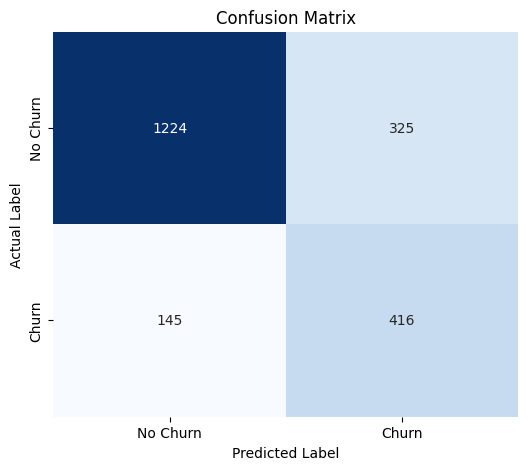

In [19]:
# Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='d',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Detailed Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1549
           1       0.56      0.74      0.64       561

    accuracy                           0.78      2110
   macro avg       0.73      0.77      0.74      2110
weighted avg       0.81      0.78      0.79      2110



## 8. Feature Importance
Finally, we visualize which features had the biggest impact on predicting customer churn.

/tmp/ipython-input-3831844799.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Features', data=feature_importance_df, palette='viridis')


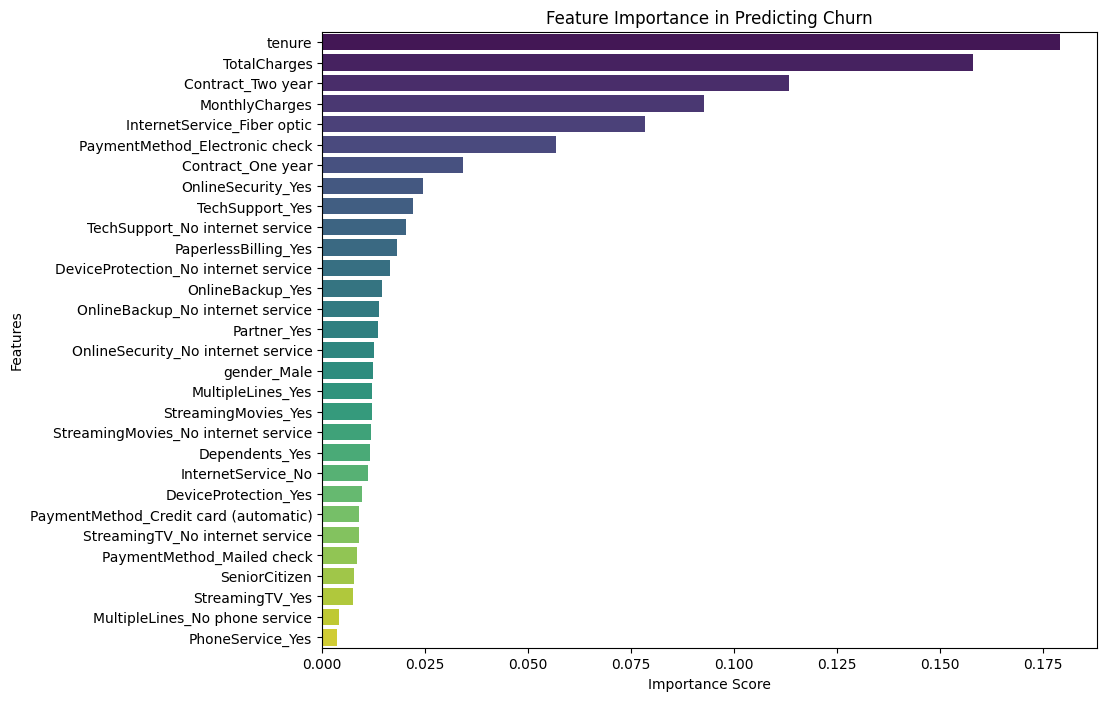

In [17]:
# Extract Feature Importance
importance = final_model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Features': X.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Features', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance in Predicting Churn')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()